In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Mon_May__3_19:15:13_PDT_2021
Cuda compilation tools, release 11.3, V11.3.109
Build cuda_11.3.r11.3/compiler.29920130_0


/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch:  1.12 ; cuda:  1.12.0
detectron2: 0.6


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import matplotlib.pyplot as plt

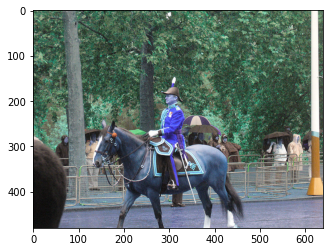

In [3]:


# !wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
plt.imshow(im)

In [4]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[02/02 14:58:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl ...


/opt/conda/lib/python3.7/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1656352464346/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
from pprint import pprint
pprint(cfg.dump())

('CUDNN_BENCHMARK: false\n'
 'DATALOADER:\n'
 '  ASPECT_RATIO_GROUPING: true\n'
 '  FILTER_EMPTY_ANNOTATIONS: true\n'
 '  NUM_WORKERS: 4\n'
 '  REPEAT_THRESHOLD: 0.0\n'
 '  SAMPLER_TRAIN: TrainingSampler\n'
 'DATASETS:\n'
 '  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000\n'
 '  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000\n'
 '  PROPOSAL_FILES_TEST: []\n'
 '  PROPOSAL_FILES_TRAIN: []\n'
 '  TEST:\n'
 '  - coco_2017_val\n'
 '  TRAIN:\n'
 '  - coco_2017_train\n'
 'GLOBAL:\n'
 '  HACK: 1.0\n'
 'INPUT:\n'
 '  CROP:\n'
 '    ENABLED: false\n'
 '    SIZE:\n'
 '    - 0.9\n'
 '    - 0.9\n'
 '    TYPE: relative_range\n'
 '  FORMAT: BGR\n'
 '  MASK_FORMAT: polygon\n'
 '  MAX_SIZE_TEST: 1333\n'
 '  MAX_SIZE_TRAIN: 1333\n'
 '  MIN_SIZE_TEST: 800\n'
 '  MIN_SIZE_TRAIN:\n'
 '  - 640\n'
 '  - 672\n'
 '  - 704\n'
 '  - 736\n'
 '  - 768\n'
 '  - 800\n'
 '  MIN_SIZE_TRAIN_SAMPLING: choice\n'
 '  RANDOM_FLIP: horizontal\n'
 'MODEL:\n'
 '  ANCHOR_GENERATOR:\n'
 '    ANGLES:\n'
 '    - - -90\n'
 '      - 0\n'
 '      - 90

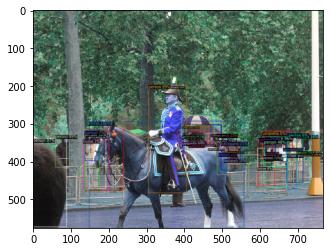

In [6]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

In [7]:
# !wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/balloon_dataset.zip
# !unzip balloon_dataset.zip > /dev/null

In [8]:
from detectron2.structures import BoxMode

def get_balloon_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("balloon_" + d, lambda d=d: get_balloon_dicts("balloon/" + d))
    MetadataCatalog.get("balloon_" + d).set(thing_classes=["balloon"])
balloon_metadata = MetadataCatalog.get("balloon_train")

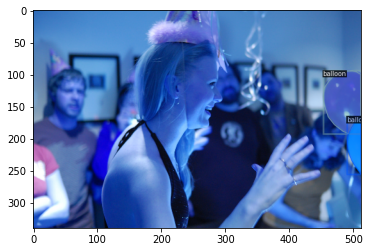

In [9]:
dataset_dicts = get_balloon_dicts("balloon/train")
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=balloon_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])

In [10]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("balloon_train",)
cfg.DATASETS.TEST = ()
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300   # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The "RoIHead batch size". 128 is faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.OUTPUT_DIR = '/app/notebooks/checkpoints'



In [11]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[02/02 14:58:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[02/02 14:58:10 d2.engine.train_loop]: Starting training from iteration 0
[02/02 14:58:12 d2.utils.events]:  eta: 0:00:33  iter: 19  total_loss: 1.297  loss_cls: 0.6429  loss_box_reg: 0.6133  loss_rpn_cls: 0.0277  loss_rpn_loc: 0.006578  time: 0.1202  data_time: 0.0166  lr: 1.6068e-05  max_mem: 2677M
[02/02 14:58:15 d2.utils.events]:  eta: 0:00:30  iter: 39  total_loss: 1.18  loss_cls: 0.55  loss_box_reg: 0.5657  loss_rpn_cls: 0.03181  loss_rpn_loc: 0.009945  time: 0.1200  data_time: 0.0024  lr: 3.2718e-05  max_mem: 2890M
[02/02 14:58:17 d2.utils.events]:  eta: 0:00:28  iter: 59  total_loss: 1.187  loss_cls: 0.4537  loss_box_reg: 0.6954  loss_rpn_cls: 0.02731  loss_rpn_loc: 0.006391  time: 0.1192  data_time: 0.0025  lr: 4.9367e-05  max_mem: 2890M
[02/02 14:58:19 d2.utils.events]:  eta: 0:00:25  iter: 79  total_loss: 1.152  loss_cls: 0.3913  loss_box_reg: 0.6917  loss_rpn_cls: 0.02569  loss_rpn_loc: 0.007165  time: 0.1185  data_time: 0.0026  lr: 6.6017e-05  max_mem: 2890M
[02/02 14:58:2

In [12]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[02/02 14:58:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /app/notebooks/checkpoints/model_final.pth ...


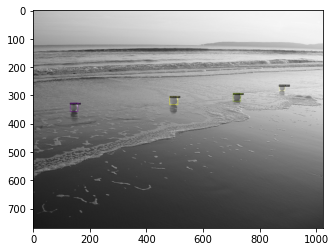

In [13]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):
    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])

In [ ]:
from pprint import pprint
pprint(cfg.dump())

In [16]:
outputs

{'instances': Instances(num_instances=4, image_height=1536, image_width=2048, fields=[pred_boxes: Boxes(tensor([[ 261.6741,  654.7041,  315.9651,  713.2230],
         [ 964.9304,  608.2680, 1022.1917,  666.4919],
         [1412.8999,  586.8296, 1466.7462,  642.5911],
         [1738.3212,  527.9290, 1777.1145,  568.6292]], device='cuda:0')), scores: tensor([0.9622, 0.9594, 0.9329, 0.9161], device='cuda:0'), pred_classes: tensor([0, 0, 0, 0], device='cuda:0')])}

# DETECTRON INFERENCE


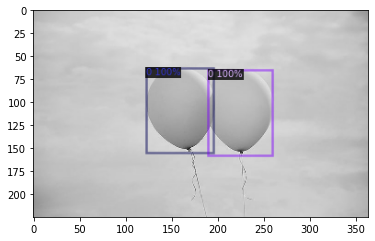

In [4]:
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import ColorMode

import matplotlib.pyplot as plt
import cv2

cfg = get_cfg()
cfg.merge_from_file('/app/configs/custom_faster_rcnn_R_50_FPN_3x.yaml')
predictor = DefaultPredictor(cfg)

im = cv2.imread('/app/dataset/test_imgs/balloons.jpg')
outputs = predictor(im)


balloon_metadata = MetadataCatalog.get("balloon_train")
v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])